In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import argparse
import time
import random
from glob import glob
from datetime import datetime

import align.detect_face
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import misc
from scipy.interpolate import Rbf
from skimage import io, transform
from six.moves import xrange

import tensorflow as tf
import tensorflow.contrib.slim as slim

import facenet
import helper

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [2]:
landmarks_frame = pd.read_csv('./face_landmarks_generate.csv')
file_list = landmarks_frame.image_name.values.tolist()

In [3]:
batch_size = 8

In [4]:
avgP_container = np.load('f_avgP_list.npz')
emb_container = np.load('f_emb_list.npz')

train_set = []
test_set = []

for key in sorted(emb_container, key=lambda x: int(x.strip('arr_'))) :
    batch = avgP_container[key], emb_container[key]
    if len(batch[0]) is batch_size :
        train_set.append(batch)
    else :
        test_set.append(batch)

test_set_index = len(train_set)

In [5]:
t_dataset = helper.Dataset('nf',file_list, 160)
print(t_dataset.shape)

(7867, 160, 160, 3)


In [6]:
print(len(train_set))

983


In [7]:
def F_layer(encoded, f_num = 128) : 
    with tf.variable_scope('F') :
        fc = slim.fully_connected(encoded, f_num, activation_fn=tf.nn.relu, scope='fc')
    return fc

In [8]:
def MLP(net, landmark_num = 68, reuse=None, scope='MLP'):
    """Builds the MLP for landmark"""
    with tf.variable_scope(scope, 'MLP') :
        net = slim.fully_connected(net, 256, activation_fn=None, scope='fc0')
        net = slim.fully_connected(net, 128, activation_fn=None, scope='fc1')
        net = slim.fully_connected(net, landmark_num, activation_fn=tf.nn.relu, scope='fc2')
    return net

In [9]:
def landmark_decode(net, landmark_num = 68):
    with tf.variable_scope('landmark') :
        decoded_x = MLP(net, scope= 'decoded_x')
        decoded_y = MLP(net, scope= 'decoded_y')
    return decoded_x, decoded_y

In [10]:
def CNN(F, size) :
    with tf.variable_scope('CNN') :
        # 12 x 12 x 256
        f_size = int(size / 8)
        features = slim.fully_connected(F, f_size * f_size * 256, activation_fn=None, scope="features")
        features = tf.reshape(features, [-1, f_size, f_size, 256])
        # print(features.shape)
        
        # 24 x 24 x 128
        upsample_0 = slim.conv2d_transpose(features, 128, 5, stride=2, scope="upsample_0")
        # print(upsample_0.shape)
        
        # 48 x 48 x 64
        upsample_1 = slim.conv2d_transpose(upsample_0, 64, 5, stride=2, scope="upsample_1")
        # print(upsample_1.shape)
        
        # 96 x 96 x 32
        upsample_2 = slim.conv2d_transpose(upsample_1, 32, 5, stride=2, scope="upsample_2")
        # print(upsample_2.shape)
        
        # 96 x 96 x 3
        one_by_one_conv = slim.conv2d(upsample_2, 3, 1, stride=1, activation_fn=None, scope="one_by_one_conv")
        # print(one_by_one_conv.shape)
    return one_by_one_conv

In [11]:
def texture_decode(net, size) :
    with tf.variable_scope('texture') :
        cnn = CNN(net, size)
    return cnn

In [12]:
def get_grids(size):
    return np.mgrid[0:size-1:(size * 1j), 0:size-1:(size * 1j)]

In [13]:
def get_zero_displacement(size):
    mid = size/2
    end = size-1
    
    zero_displacement = [[0,0], 
                         [0, mid], 
                         [0, end], 
                         [mid, 0], 
                         [end,0], 
                         [end, mid], 
                         [end, end], 
                         [mid, end]]
    return zero_displacement

In [68]:
def rbf_tf(pred_x, pred_y, correct_points, grids, grid_shape):
    def _euclidean_norm_tf(x1, x2):
        euclidean_norm = tf.subtract(x1, x2)
        euclidean_norm = tf.square(euclidean_norm)
        euclidean_norm = tf.reduce_sum(euclidean_norm, 1)
        euclidean_norm = tf.clip_by_value(euclidean_norm, 0.1, 10**5)
        euclidean_norm = tf.sqrt(euclidean_norm)
        return euclidean_norm
        
        with tf.variable_scope('euclidean_norm') :
            euclidean_norm = tf.sqrt(tf.reduce_sum(((x1 - x2)**2), 1))
        return euclidean_norm

    def _h_linear_tf(r):
        return r

    def _call_norm_tf(x1, x2):
        with tf.variable_scope('norm') :
            x1 = tf.expand_dims(x1, 3)
            x2 = tf.expand_dims(x2, 2)
            n = norm(x1, x2)
        return n

    # set parameters
    norm = _euclidean_norm_tf
    basis_function = _h_linear_tf
    epsilon = tf.constant(2.)
    smooth = tf.constant(1.)

    xi = tf.stack([pred_x, pred_y], axis= 1)
    N = xi.shape[-1].value # same as landmarks_num => 76
    di = tf.expand_dims(correct_points, 2) # (None, 76, 1)
    
    r = _call_norm_tf(xi, xi) # (None, 76, 76)
    
    batch_shape = tf.shape(pred_x)[0:1]
    A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= batch_shape)))
    
    nodes = tf.matrix_solve (A, di)
    r2 = _call_norm_tf(grids, xi)
    return tf.reshape(tf.matmul(r2, nodes), [-1, grid_shape[0], grid_shape[1]])

In [69]:
def warp_tf(data, pred_x, pred_y, correct_x, correct_y, grids, grid_shape, zero_displacement) :
    with tf.variable_scope('pred') :
        pred_x_zd = tf.concat([pred_x, zero_displacement[0]], axis=1)
        pred_y_zd = tf.concat([pred_y, zero_displacement[1]], axis=1)
    with tf.variable_scope('correct') :
        correct_x_zd = tf.concat([correct_x, zero_displacement[0]], axis=1)
        correct_y_zd = tf.concat([correct_y, zero_displacement[1]], axis=1)

    with tf.variable_scope('rbf_x') :
        rbf_x = rbf_tf(pred_x_zd, pred_y_zd, correct_x_zd, grids, grid_shape)
    with tf.variable_scope('rbf_y') :
        rbf_y = rbf_tf(pred_x_zd, pred_y_zd, correct_y_zd, grids, grid_shape)

    with tf.variable_scope('resample') :
        warp = tf.stack([rbf_x, rbf_y], axis= 3)
        resample = tf.contrib.resampler.resampler(data=data, warp=warp)
    return resample

In [70]:
# summary
base_dir = 'logs'
subdir = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
log_dir = os.path.join(base_dir, subdir)
print(log_dir)
# log_dir = os.path.join(os.path.expanduser(args.logs_base_dir), subdir)

# hyperparam
epochs = 200

avgP_num = 1792
emb_num = 128
f_num = 128

l_num = 68
zd_l_num = 76
t_size = 160
t_channel = 3

grid_y, grid_x = get_grids(t_size)
grid_shape = grid_x.shape

_xa = np.asarray([a.flatten() for a in [grid_x, grid_y]], dtype=np.float32) # (2, 25600)
xa = np.asarray([_xa for _ in range(0, batch_size)], dtype=np.float32) # (batch_size, 2, 25600)
xa_t = np.asarray([_xa], dtype=np.float32)

_zd = get_zero_displacement(t_size)
zd = np.asarray([_zd for _ in range(0, batch_size)], dtype=np.float32)
zd_t = np.asarray([_zd], dtype=np.float32)

logs/20171016-124231


In [71]:
g = tf.Graph()
with g.as_default():
    global_step = tf.Variable(0, trainable=False)
    
    # placeholder
    avgP_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='avgP_inputs')
    
    l_x_labels = tf.placeholder(tf.float32, (None, l_num), name='l_x_labels')
    l_y_labels = tf.placeholder(tf.float32, (None, l_num), name='l_y_labels')
    t_labels = tf.placeholder(tf.float32, (None, t_size, t_size, t_channel), name='t_labels')
    w_labels = tf.placeholder(tf.float32, shape=(None, emb_num), name= 'w_labels')
    
    grids = tf.constant(xa, dtype=tf.float32, name= 'grids')
    grids_test = tf.constant(xa_t, dtype=tf.float32, name= 'grids')
    
    zero_displacement = (tf.constant(zd[:, :, 0], dtype=tf.float32, name= 'zd_x'), 
                         tf.constant(zd[:, :, 1], dtype=tf.float32, name= 'zd_y'))
    zero_displacement_test = (tf.constant(zd_t[:, :, 0], dtype=tf.float32, name= 'zd_x_t'), 
                              tf.constant(zd_t[:, :, 1], dtype=tf.float32, name= 'zd_y_t'))
    
    # model
    F = F_layer(avgP_inputs, f_num= f_num)
    
    (l_x_preds, l_y_preds) = landmark_decode(F, landmark_num= l_num)
    
    l_x_loss = tf.losses.mean_squared_error(l_x_labels, l_x_preds, reduction="weighted_mean")
    l_y_loss = tf.losses.mean_squared_error(l_y_labels, l_y_preds, reduction="weighted_mean")
    
    l_loss = tf.add(l_x_loss, l_y_loss)
    
    t_preds = texture_decode(F, t_size)
    t_loss = tf.losses.absolute_difference(t_labels, t_preds)
    
    with tf.variable_scope('warp') :
        warp = warp_tf(t_preds, 
                       l_x_preds, 
                       l_y_preds, 
                       l_x_labels, 
                       l_y_labels, 
                       grids, 
                       grid_shape, 
                       zero_displacement)
        
    with tf.variable_scope('warp_t') :
        warp_t = warp_tf(t_preds, 
                         l_x_preds, 
                         l_y_preds, 
                         l_x_labels, 
                         l_y_labels, 
                         grids_test, 
                         grid_shape, 
                         zero_displacement_test)
        warp_t = tf.cast(warp_t, tf.uint8)
    
    # w_loss = tf.losses.mean_squared_error(t_labels, warp)
    # total_cost = l_loss + t_loss + w_loss

In [72]:
with g.as_default():
    time_load_data = time.time()
    
    #facenet
    start_load_facenet = time.time()
    print("--- %s start load facenet ---" % (start_load_facenet))
    facenet.load_model('./20171012', input_map={"input:0": warp})
    print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

    f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    w_preds = tf.get_default_graph().get_tensor_by_name("embeddings:0")    
    w_loss = tf.losses.cosine_distance(tf.nn.l2_normalize(w_labels, 1), 
                                       tf.nn.l2_normalize(w_preds, 1), dim=1)
    
    total_cost = l_loss + t_loss + w_loss
    
    opt = tf.train.AdamOptimizer(0.001)# .minimize(total_cost)
    
    sess = tf.Session()
    
    grads = tf.gradients(total_cost, tf.trainable_variables())
    grads = list(zip(grads, tf.trainable_variables()))
    apply_grads = opt.apply_gradients(grads_and_vars=grads)
    
    for grad, var in grads:
        tf.summary.histogram(var.op.name + '/gradient', grad)
    
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    
    summary_op = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)    
    
    sess.run(tf.global_variables_initializer())

--- 1508157757.4999802 start load facenet ---
Model filename: ./20171012
--- 5.749683856964111 facenet loaded ---


In [73]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

In [74]:
def get_landmarks(index) :
    index = len(train_set) * batch_size + index
    return landmarks_frame.ix[index]

In [75]:
def show_test(l_x, l_y, t, w, img, l):
    plt.figure()
    show_landmarks(io.imread(os.path.join('', img)), l)
    plt.show()
    
#     t_img = scipy.misc.toimage(t)
#     plt.imshow(t_img)
#     plt.scatter(l_x, l_y, s=10, marker='.', c='b')
#     plt.pause(0.001)
#     plt.show()

    plt.scatter(l_x, l_y, s=10, marker='.', c='r')
    plt.imshow(w)
    plt.show()
#     plt.imshow(np.squeeze(w, axis=0))
#     plt.show()

In [76]:
print(test_set[0][0].shape)

(3, 1, 1, 1792)


Iter: 10/983 Training loss: X = 709.8238, Y = 780.4318, T = 13.9241, W = 0.0869
Iter: 20/983 Training loss: X = 521.6927, Y = 514.2373, T = 7.1678, W = 0.0855
Iter: 30/983 Training loss: X = 280.9609, Y = 300.9301, T = 8.8171, W = 0.0946
Iter: 40/983 Training loss: X = 146.7069, Y = 155.4616, T = 5.9543, W = 0.1072
Iter: 50/983 Training loss: X = 363.2442, Y = 404.6371, T = 6.3449, W = 0.0910
Iter: 60/983 Training loss: X = 187.1168, Y = 194.7974, T = 6.9064, W = 0.0969
Iter: 70/983 Training loss: X = 157.9616, Y = 169.0474, T = 6.9360, W = 0.0951
Iter: 80/983 Training loss: X = 364.2217, Y = 375.4390, T = 6.8295, W = 0.0793
Iter: 90/983 Training loss: X = 347.2000, Y = 323.2558, T = 9.1619, W = 0.0916
Iter: 100/983 Training loss: X = 217.2365, Y = 263.1313, T = 6.2821, W = 0.1071


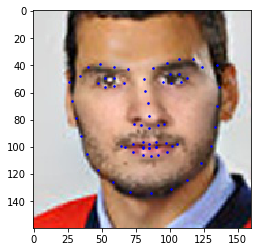

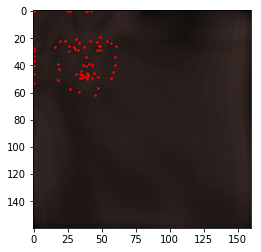

Iter: 110/983 Training loss: X = 217.6155, Y = 245.7042, T = 10.4080, W = 0.0881
Iter: 120/983 Training loss: X = 140.0796, Y = 147.8574, T = 6.1398, W = 0.0883
Iter: 130/983 Training loss: X = 211.0066, Y = 257.5755, T = 7.0918, W = 0.1002
Iter: 140/983 Training loss: X = 192.4898, Y = 213.3631, T = 5.1218, W = 0.0949
Iter: 150/983 Training loss: X = 201.7197, Y = 201.6200, T = 6.3218, W = 0.0911
Iter: 160/983 Training loss: X = 145.8701, Y = 148.5482, T = 4.8172, W = 0.0897
Iter: 170/983 Training loss: X = 134.9583, Y = 149.1311, T = 5.8343, W = 0.0937
Iter: 180/983 Training loss: X = 130.1367, Y = 132.0224, T = 4.7357, W = 0.1073
Iter: 190/983 Training loss: X = 132.4434, Y = 142.0111, T = 4.5533, W = 0.1030
Iter: 200/983 Training loss: X = 653.9191, Y = 678.3884, T = 12.6544, W = 0.1032


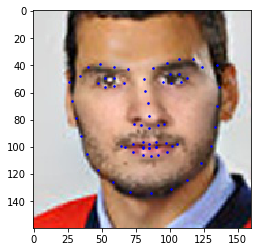

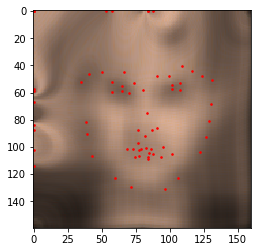

Iter: 210/983 Training loss: X = 104.5476, Y = 113.1162, T = 8.8010, W = 0.0910
Iter: 220/983 Training loss: X = 224.3454, Y = 243.7592, T = 6.8180, W = 0.1110
Iter: 230/983 Training loss: X = 128.8367, Y = 157.1371, T = 5.1307, W = 0.1086
Iter: 240/983 Training loss: X = 198.6062, Y = 201.3551, T = 9.4395, W = 0.0719
Iter: 250/983 Training loss: X = 125.0117, Y = 146.5395, T = 6.1088, W = 0.0983
Iter: 260/983 Training loss: X = 286.1953, Y = 282.8570, T = 9.2192, W = 0.0903
Iter: 270/983 Training loss: X = 168.2715, Y = 167.3471, T = 7.9087, W = 0.0999
Iter: 280/983 Training loss: X = 157.4348, Y = 184.0832, T = 6.8632, W = 0.0888
Iter: 290/983 Training loss: X = 153.9011, Y = 153.0861, T = 5.6115, W = 0.0897
Iter: 300/983 Training loss: X = 136.0055, Y = 164.5227, T = 6.0952, W = 0.1003


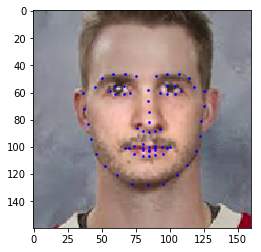

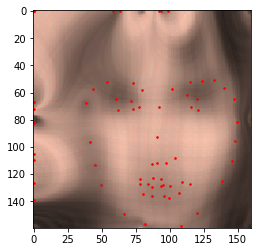

Iter: 310/983 Training loss: X = 145.7694, Y = 156.7794, T = 8.5054, W = 0.0998
Iter: 320/983 Training loss: X = 210.8646, Y = 225.3799, T = 5.1130, W = 0.0953
Iter: 330/983 Training loss: X = 278.9020, Y = 315.3789, T = 6.6642, W = 0.0882
Iter: 340/983 Training loss: X = 152.2488, Y = 192.7799, T = 6.4626, W = 0.0981
Iter: 350/983 Training loss: X = 136.4093, Y = 135.8051, T = 5.8818, W = 0.0849
Iter: 360/983 Training loss: X = 112.8077, Y = 127.2159, T = 6.1061, W = 0.0978
Iter: 370/983 Training loss: X = 205.1035, Y = 232.8624, T = 6.0509, W = 0.1094
Iter: 380/983 Training loss: X = 109.2910, Y = 117.4950, T = 5.1122, W = 0.0977
Iter: 390/983 Training loss: X = 136.1257, Y = 161.0885, T = 6.0989, W = 0.1029
Iter: 400/983 Training loss: X = 120.5336, Y = 127.3211, T = 6.3429, W = 0.0798


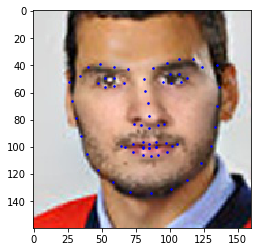

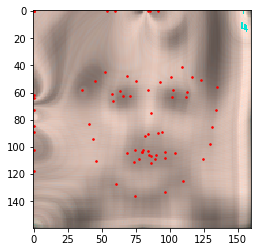

Iter: 410/983 Training loss: X = 127.0240, Y = 130.7172, T = 6.9545, W = 0.1023
Iter: 420/983 Training loss: X = 134.3367, Y = 159.1877, T = 4.4050, W = 0.0963
Iter: 430/983 Training loss: X = 124.1470, Y = 145.8126, T = 4.8988, W = 0.0880
Iter: 440/983 Training loss: X = 121.8365, Y = 134.4874, T = 5.8420, W = 0.0986
Iter: 450/983 Training loss: X = 117.9292, Y = 135.0140, T = 6.2677, W = 0.0975
Iter: 460/983 Training loss: X = 113.1689, Y = 123.5664, T = 6.2924, W = 0.1029
Iter: 470/983 Training loss: X = 109.2250, Y = 110.2676, T = 4.4033, W = 0.0971
Iter: 480/983 Training loss: X = 119.2464, Y = 150.7418, T = 5.3770, W = 0.0995
Iter: 490/983 Training loss: X = 114.4835, Y = 117.3860, T = 4.7540, W = 0.0917
Iter: 500/983 Training loss: X = 110.2843, Y = 111.9622, T = 5.2837, W = 0.0903


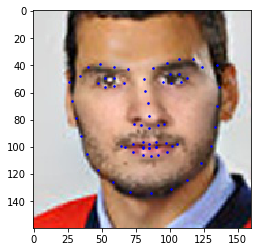

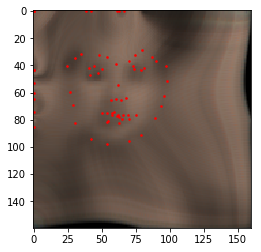

Iter: 510/983 Training loss: X = 125.1010, Y = 111.1215, T = 8.3583, W = 0.0702
Iter: 520/983 Training loss: X = 160.7279, Y = 162.5669, T = 10.1122, W = 0.0863
Iter: 530/983 Training loss: X = 182.2694, Y = 176.7105, T = 4.9635, W = 0.0935
Iter: 540/983 Training loss: X = 112.9148, Y = 125.5066, T = 6.0689, W = 0.0985
Iter: 550/983 Training loss: X = 111.4936, Y = 116.6332, T = 4.6667, W = 0.0803
Iter: 560/983 Training loss: X = 113.4872, Y = 133.8932, T = 4.4197, W = 0.0837
Iter: 570/983 Training loss: X = 135.5854, Y = 142.2151, T = 7.4425, W = 0.0823
Iter: 580/983 Training loss: X = 114.0835, Y = 108.6794, T = 6.8791, W = 0.0848
Iter: 590/983 Training loss: X = 118.4858, Y = 126.3482, T = 5.8771, W = 0.0879
Iter: 600/983 Training loss: X = 119.4405, Y = 115.0634, T = 4.9987, W = 0.0879


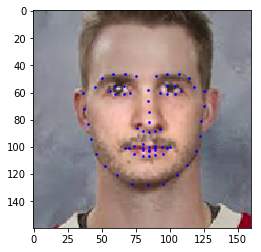

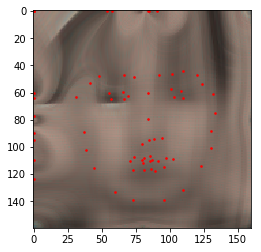

Iter: 610/983 Training loss: X = 100.6773, Y = 107.7102, T = 5.7391, W = 0.0803
Iter: 620/983 Training loss: X = 135.6827, Y = 144.4831, T = 5.0148, W = 0.0874
Iter: 630/983 Training loss: X = 115.1153, Y = 116.0653, T = 6.1632, W = 0.0865
Iter: 640/983 Training loss: X = 111.1498, Y = 112.0363, T = 6.9635, W = 0.0921
Iter: 650/983 Training loss: X = 114.4760, Y = 121.4705, T = 7.4685, W = 0.0971
Iter: 660/983 Training loss: X = 108.0312, Y = 121.3068, T = 5.1744, W = 0.1142
Iter: 670/983 Training loss: X = 132.4216, Y = 130.3097, T = 7.8850, W = 0.0886
Iter: 680/983 Training loss: X = 112.2795, Y = 123.7923, T = 4.1305, W = 0.0966
Iter: 690/983 Training loss: X = 117.0154, Y = 119.2700, T = 4.1038, W = 0.0965
Iter: 700/983 Training loss: X = 124.3675, Y = 121.5790, T = 4.9750, W = 0.0967


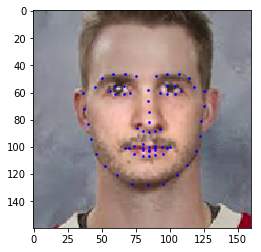

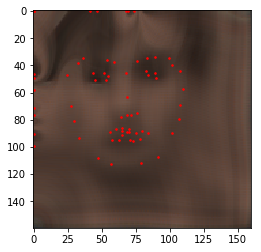

Iter: 710/983 Training loss: X = 112.8419, Y = 115.9597, T = 8.3855, W = 0.0823
Iter: 720/983 Training loss: X = 122.0204, Y = 127.5696, T = 6.5806, W = 0.1004
Iter: 730/983 Training loss: X = 106.6207, Y = 120.3155, T = 7.2951, W = 0.1009
Iter: 740/983 Training loss: X = 108.7592, Y = 107.0083, T = 4.8190, W = 0.0790
Iter: 750/983 Training loss: X = 141.6340, Y = 135.5941, T = 3.8547, W = 0.0968
Iter: 760/983 Training loss: X = 109.0488, Y = 115.7561, T = 5.6479, W = 0.0812
Iter: 770/983 Training loss: X = 116.6237, Y = 138.9287, T = 5.7067, W = 0.0916
Iter: 780/983 Training loss: X = 140.9777, Y = 148.2448, T = 7.8807, W = 0.0972
Iter: 790/983 Training loss: X = 116.0726, Y = 136.0649, T = 6.2180, W = 0.0952
Iter: 800/983 Training loss: X = 127.2501, Y = 150.4701, T = 5.5379, W = 0.0973


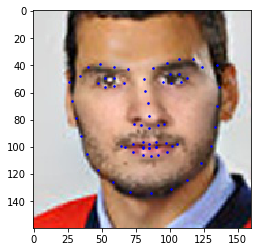

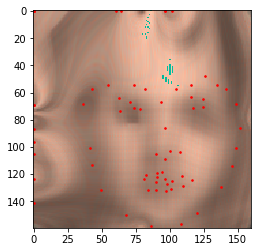

Iter: 810/983 Training loss: X = 134.6992, Y = 162.3393, T = 4.2452, W = 0.1009
Iter: 820/983 Training loss: X = 138.1726, Y = 129.0983, T = 8.0924, W = 0.1086
Iter: 830/983 Training loss: X = 117.0156, Y = 123.4491, T = 5.0173, W = 0.0874
Iter: 840/983 Training loss: X = 110.0594, Y = 126.0007, T = 4.6185, W = 0.1026
Iter: 850/983 Training loss: X = 110.2024, Y = 113.2646, T = 4.4559, W = 0.0831
Iter: 860/983 Training loss: X = 109.7633, Y = 111.6369, T = 8.7129, W = 0.1070
Iter: 870/983 Training loss: X = 112.3454, Y = 114.7363, T = 4.6028, W = 0.0884
Iter: 880/983 Training loss: X = 104.5946, Y = 104.5500, T = 5.9740, W = 0.0965
Iter: 890/983 Training loss: X = 106.0985, Y = 125.7890, T = 5.4349, W = 0.0993
Iter: 900/983 Training loss: X = 102.7304, Y = 120.3790, T = 4.8503, W = 0.0917


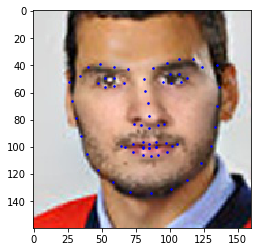

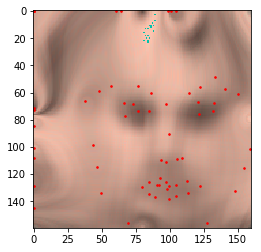

Iter: 910/983 Training loss: X = 109.4335, Y = 118.4517, T = 4.3042, W = 0.0936
Iter: 920/983 Training loss: X = 117.0824, Y = 119.5788, T = 3.4356, W = 0.1005
Iter: 930/983 Training loss: X = 105.4918, Y = 106.0388, T = 4.8094, W = 0.0937
Iter: 940/983 Training loss: X = 121.5145, Y = 121.4050, T = 5.4589, W = 0.0904
Iter: 950/983 Training loss: X = 111.9829, Y = 125.4032, T = 5.4154, W = 0.0870
Iter: 960/983 Training loss: X = 110.8297, Y = 118.4372, T = 5.1276, W = 0.0864
Iter: 970/983 Training loss: X = 110.1796, Y = 110.0175, T = 4.3882, W = 0.0855
Iter: 980/983 Training loss: X = 118.9671, Y = 139.5638, T = 5.3216, W = 0.0892
Epoch: 1/200 Time: 441.10439372062683
Model saved in file: ./tmp/model_1.ckpt Time: 446.2736773490906
Iter: 10/983 Training loss: X = 144.4405, Y = 154.4759, T = 7.2065, W = 0.0888
Iter: 20/983 Training loss: X = 115.1736, Y = 115.8276, T = 4.8327, W = 0.0816
Iter: 30/983 Training loss: X = 119.1699, Y = 129.4802, T = 5.2174, W = 0.0913
Iter: 40/983 Training

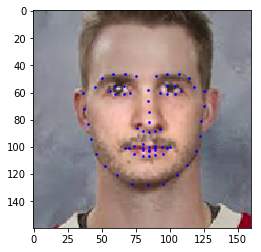

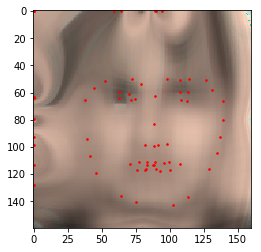

Iter: 110/983 Training loss: X = 158.3323, Y = 176.4280, T = 4.8878, W = 0.0906
Iter: 120/983 Training loss: X = 116.2967, Y = 129.5386, T = 5.2940, W = 0.0902
Iter: 130/983 Training loss: X = 148.6176, Y = 161.7628, T = 5.1535, W = 0.0982
Iter: 140/983 Training loss: X = 126.2654, Y = 136.7526, T = 5.1073, W = 0.0996
Iter: 150/983 Training loss: X = 130.2450, Y = 133.1307, T = 5.9260, W = 0.0912
Iter: 160/983 Training loss: X = 109.4839, Y = 112.7844, T = 4.5165, W = 0.0913
Iter: 170/983 Training loss: X = 131.8548, Y = 145.8020, T = 5.2210, W = 0.0936
Iter: 180/983 Training loss: X = 109.4126, Y = 122.3822, T = 5.7257, W = 0.1005
Iter: 190/983 Training loss: X = 110.5905, Y = 116.8995, T = 3.9971, W = 0.1009
Iter: 200/983 Training loss: X = 151.7843, Y = 163.0597, T = 4.7450, W = 0.1038


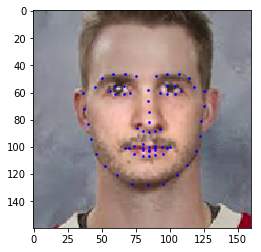

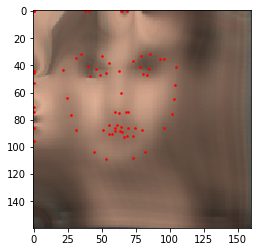

Iter: 210/983 Training loss: X = 135.2455, Y = 139.0963, T = 4.6893, W = 0.0885
Iter: 220/983 Training loss: X = 105.0881, Y = 113.4702, T = 3.9370, W = 0.1099
Iter: 230/983 Training loss: X = 119.5634, Y = 132.1835, T = 4.5167, W = 0.1112
Iter: 240/983 Training loss: X = 125.8485, Y = 127.6332, T = 7.7913, W = 0.0828
Iter: 250/983 Training loss: X = 124.6679, Y = 126.0682, T = 4.9428, W = 0.1033
Iter: 260/983 Training loss: X = 117.4721, Y = 113.8520, T = 5.6952, W = 0.0960
Iter: 270/983 Training loss: X = 134.8252, Y = 144.1553, T = 5.3471, W = 0.1009
Iter: 280/983 Training loss: X = 115.6710, Y = 126.7129, T = 5.1057, W = 0.0949
Iter: 290/983 Training loss: X = 110.8451, Y = 111.4730, T = 3.6574, W = 0.0927
Iter: 300/983 Training loss: X = 115.3051, Y = 148.8969, T = 6.4164, W = 0.1000


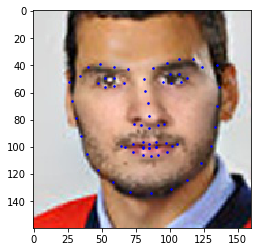

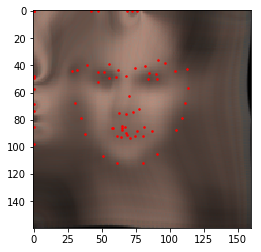

Iter: 310/983 Training loss: X = 129.6873, Y = 140.2263, T = 7.0882, W = 0.0903
Iter: 320/983 Training loss: X = 122.1787, Y = 127.4368, T = 4.5716, W = 0.0915
Iter: 330/983 Training loss: X = 111.6631, Y = 126.9586, T = 4.6629, W = 0.0850
Iter: 340/983 Training loss: X = 105.2409, Y = 124.5908, T = 7.3845, W = 0.0935
Iter: 350/983 Training loss: X = 121.3709, Y = 140.9135, T = 5.5339, W = 0.0803
Iter: 360/983 Training loss: X = 109.5409, Y = 120.9238, T = 5.4482, W = 0.0882
Iter: 370/983 Training loss: X = 218.1839, Y = 226.5480, T = 5.9589, W = 0.1102
Iter: 380/983 Training loss: X = 153.7524, Y = 177.1646, T = 5.2661, W = 0.0897
Iter: 390/983 Training loss: X = 110.9570, Y = 121.4836, T = 4.6497, W = 0.0970
Iter: 400/983 Training loss: X = 102.8464, Y = 106.1601, T = 4.3172, W = 0.0809


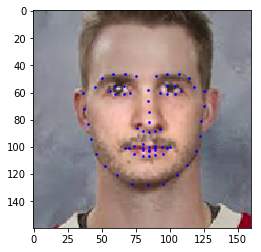

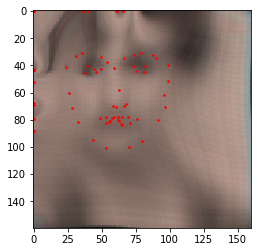

Iter: 410/983 Training loss: X = 114.8338, Y = 123.8399, T = 5.6017, W = 0.0946
Iter: 420/983 Training loss: X = 104.7621, Y = 120.2259, T = 4.6851, W = 0.0896
Iter: 430/983 Training loss: X = 103.0330, Y = 121.7231, T = 4.1759, W = 0.0778
Iter: 440/983 Training loss: X = 111.8441, Y = 118.3127, T = 5.3875, W = 0.0866
Iter: 450/983 Training loss: X = 119.1428, Y = 129.6831, T = 5.4795, W = 0.0874
Iter: 460/983 Training loss: X = 120.3872, Y = 124.6913, T = 5.6053, W = 0.0955
Iter: 470/983 Training loss: X = 107.0038, Y = 108.7713, T = 4.8005, W = 0.0909
Iter: 480/983 Training loss: X = 110.6228, Y = 138.4007, T = 5.4826, W = 0.0890
Iter: 490/983 Training loss: X = 118.0090, Y = 128.9917, T = 4.4527, W = 0.0841
Iter: 500/983 Training loss: X = 107.8045, Y = 108.8252, T = 5.5731, W = 0.0847


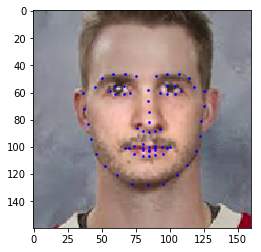

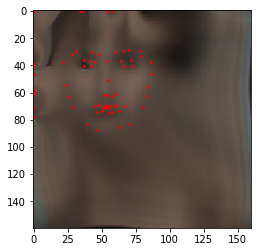

Iter: 510/983 Training loss: X = 110.8255, Y = 108.3241, T = 7.2996, W = 0.0725
Iter: 520/983 Training loss: X = 112.6295, Y = 117.6639, T = 5.7116, W = 0.0850
Iter: 530/983 Training loss: X = 138.5034, Y = 132.3185, T = 5.0653, W = 0.0933
Iter: 540/983 Training loss: X = 110.3373, Y = 120.3293, T = 5.4283, W = 0.0907
Iter: 550/983 Training loss: X = 112.4718, Y = 116.5622, T = 6.2301, W = 0.0788
Iter: 560/983 Training loss: X = 125.1182, Y = 144.9602, T = 4.2229, W = 0.0868
Iter: 570/983 Training loss: X = 143.8864, Y = 137.1558, T = 5.1856, W = 0.0799
Iter: 580/983 Training loss: X = 111.6219, Y = 116.6269, T = 4.6669, W = 0.0811
Iter: 590/983 Training loss: X = 127.0697, Y = 135.2316, T = 5.6597, W = 0.0859
Iter: 600/983 Training loss: X = 130.6266, Y = 124.2725, T = 4.7008, W = 0.0917


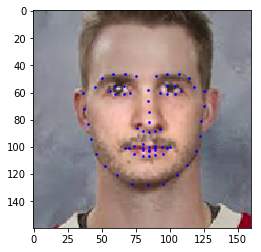

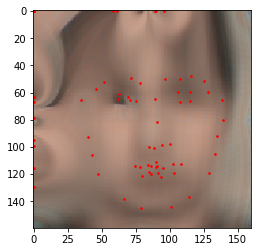

Iter: 610/983 Training loss: X = 125.4272, Y = 134.2597, T = 5.9859, W = 0.0786
Iter: 620/983 Training loss: X = 117.2159, Y = 126.6810, T = 5.0298, W = 0.0857
Iter: 630/983 Training loss: X = 136.9522, Y = 132.2324, T = 6.0988, W = 0.0916
Iter: 640/983 Training loss: X = 102.7641, Y = 106.4876, T = 5.9106, W = 0.0909
Iter: 650/983 Training loss: X = 121.0127, Y = 127.5915, T = 6.5899, W = 0.0954
Iter: 660/983 Training loss: X = 106.7098, Y = 92.9399, T = 5.0411, W = 0.1145
Iter: 670/983 Training loss: X = 132.4674, Y = 106.8276, T = 7.8329, W = 0.0863
Iter: 680/983 Training loss: X = 105.9625, Y = 88.7474, T = 3.8897, W = 0.0937
Iter: 690/983 Training loss: X = 106.0946, Y = 86.7590, T = 3.7093, W = 0.0977
Iter: 700/983 Training loss: X = 124.2224, Y = 91.3636, T = 4.9049, W = 0.0942


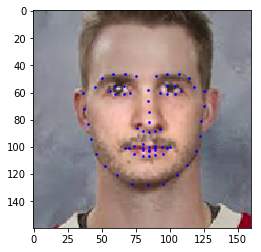

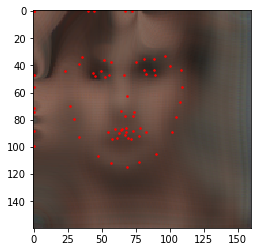

Iter: 710/983 Training loss: X = 108.7728, Y = 88.3209, T = 7.6535, W = 0.0763
Iter: 720/983 Training loss: X = 108.2772, Y = 89.5753, T = 5.8647, W = 0.0978
Iter: 730/983 Training loss: X = 103.2544, Y = 89.2705, T = 5.8501, W = 0.0977
Iter: 740/983 Training loss: X = 105.7913, Y = 85.0727, T = 3.8632, W = 0.0760
Iter: 750/983 Training loss: X = 125.7735, Y = 89.8629, T = 3.4438, W = 0.0921
Iter: 760/983 Training loss: X = 107.8730, Y = 87.8725, T = 5.2589, W = 0.0826
Iter: 770/983 Training loss: X = 115.8952, Y = 111.7220, T = 6.3109, W = 0.0917
Iter: 780/983 Training loss: X = 108.3550, Y = 91.8268, T = 6.0547, W = 0.0992
Iter: 790/983 Training loss: X = 103.1297, Y = 90.2746, T = 4.3784, W = 0.0933
Iter: 800/983 Training loss: X = 107.8518, Y = 91.5733, T = 5.9417, W = 0.1004


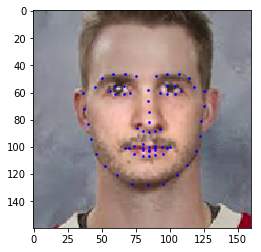

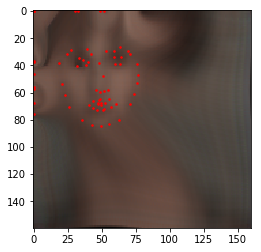

Iter: 810/983 Training loss: X = 125.7037, Y = 122.3412, T = 3.9805, W = 0.1007
Iter: 820/983 Training loss: X = 114.3069, Y = 92.7758, T = 5.8434, W = 0.1080
Iter: 830/983 Training loss: X = 148.0062, Y = 128.5661, T = 4.6885, W = 0.0891
Iter: 840/983 Training loss: X = 116.4932, Y = 112.2589, T = 4.6468, W = 0.1004
Iter: 850/983 Training loss: X = 123.5384, Y = 114.3543, T = 4.3081, W = 0.0789
Iter: 860/983 Training loss: X = 125.6423, Y = 101.8710, T = 8.4237, W = 0.1000
Iter: 870/983 Training loss: X = 117.7810, Y = 98.9070, T = 5.1278, W = 0.0885
Iter: 880/983 Training loss: X = 113.4656, Y = 83.1208, T = 4.8287, W = 0.0994
Iter: 890/983 Training loss: X = 120.5218, Y = 114.5416, T = 6.0358, W = 0.1020
Iter: 900/983 Training loss: X = 102.4265, Y = 89.3943, T = 4.2369, W = 0.0907


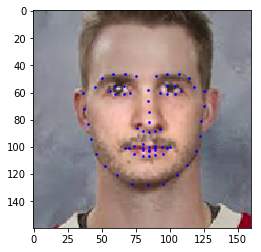

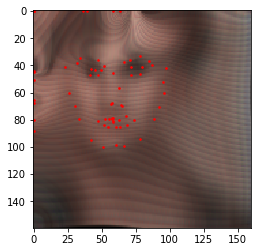

Iter: 910/983 Training loss: X = 114.9519, Y = 103.5902, T = 4.7357, W = 0.0910
Iter: 920/983 Training loss: X = 109.4536, Y = 84.2507, T = 3.1489, W = 0.0999
Iter: 930/983 Training loss: X = 102.3750, Y = 77.7309, T = 4.0696, W = 0.0933
Iter: 940/983 Training loss: X = 121.4852, Y = 102.6592, T = 5.2374, W = 0.0853
Iter: 950/983 Training loss: X = 105.4911, Y = 92.5435, T = 4.6375, W = 0.0825
Iter: 960/983 Training loss: X = 106.1117, Y = 86.6914, T = 4.8008, W = 0.0869
Iter: 970/983 Training loss: X = 114.6007, Y = 87.3733, T = 4.9033, W = 0.0809
Iter: 980/983 Training loss: X = 122.2229, Y = 119.2425, T = 5.2163, W = 0.0886
Epoch: 2/200 Time: 884.4365239143372
Model saved in file: ./tmp/model_1.ckpt Time: 889.6470890045166
Iter: 10/983 Training loss: X = 123.4094, Y = 104.5549, T = 5.9659, W = 0.0942
Iter: 20/983 Training loss: X = 111.0184, Y = 85.7663, T = 4.7470, W = 0.0836
Iter: 30/983 Training loss: X = 182.7745, Y = 185.9036, T = 5.7363, W = 0.0881
Iter: 40/983 Training loss: 

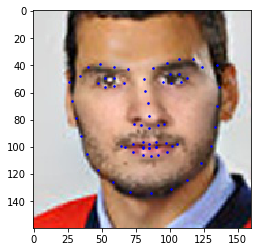

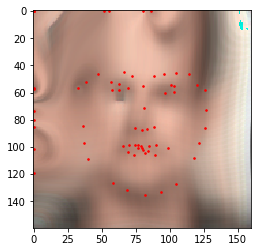

Iter: 110/983 Training loss: X = 138.9248, Y = 125.3644, T = 5.5247, W = 0.0866
Iter: 120/983 Training loss: X = 119.3521, Y = 110.2274, T = 5.6195, W = 0.0905
Iter: 130/983 Training loss: X = 113.6147, Y = 92.5235, T = 4.9623, W = 0.0989
Iter: 140/983 Training loss: X = 111.3236, Y = 94.6638, T = 3.9876, W = 0.1013
Iter: 150/983 Training loss: X = 131.4458, Y = 108.4576, T = 5.3640, W = 0.0922
Iter: 160/983 Training loss: X = 106.7439, Y = 88.6127, T = 4.7519, W = 0.0904
Iter: 170/983 Training loss: X = 124.5099, Y = 109.7089, T = 5.2562, W = 0.0942
Iter: 180/983 Training loss: X = 107.2783, Y = 93.7289, T = 6.1864, W = 0.1029
Iter: 190/983 Training loss: X = 108.9857, Y = 89.5255, T = 3.9022, W = 0.0977
Iter: 200/983 Training loss: X = 114.5907, Y = 92.0325, T = 4.8119, W = 0.1031


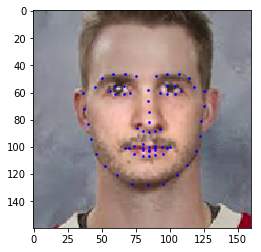

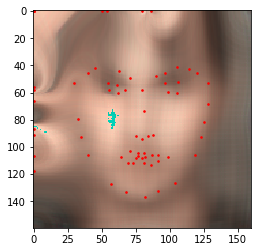

Iter: 210/983 Training loss: X = 102.0393, Y = 85.8392, T = 4.0873, W = 0.0828
Iter: 220/983 Training loss: X = 109.4435, Y = 90.1468, T = 3.8050, W = 0.1110
Iter: 230/983 Training loss: X = 108.2551, Y = 91.6848, T = 4.4660, W = 0.1115
Iter: 240/983 Training loss: X = 108.8482, Y = 80.9432, T = 5.5335, W = 0.0743
Iter: 250/983 Training loss: X = 123.4291, Y = 98.7190, T = 4.8041, W = 0.1010
Iter: 260/983 Training loss: X = 110.6580, Y = 84.8517, T = 4.4824, W = 0.0960
Iter: 270/983 Training loss: X = 110.2158, Y = 86.7337, T = 4.8823, W = 0.1023
Iter: 280/983 Training loss: X = 112.6357, Y = 93.6836, T = 4.1194, W = 0.0929
Iter: 290/983 Training loss: X = 111.5528, Y = 86.3981, T = 3.9637, W = 0.0926
Iter: 300/983 Training loss: X = 106.1078, Y = 109.3702, T = 5.7053, W = 0.0964


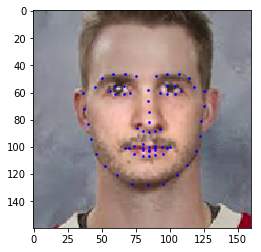

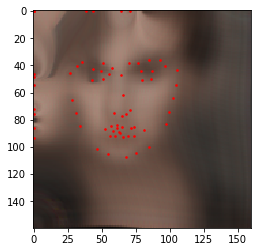

Iter: 310/983 Training loss: X = 126.8660, Y = 101.9554, T = 6.7111, W = 0.0968
Iter: 320/983 Training loss: X = 130.9468, Y = 125.6588, T = 5.3314, W = 0.0924
Iter: 330/983 Training loss: X = 111.7358, Y = 106.6943, T = 3.6782, W = 0.0884
Iter: 340/983 Training loss: X = 108.4322, Y = 94.0743, T = 5.9624, W = 0.0945
Iter: 350/983 Training loss: X = 111.7594, Y = 88.7029, T = 4.8026, W = 0.0770
Iter: 360/983 Training loss: X = 104.6862, Y = 87.4976, T = 4.5739, W = 0.0940
Iter: 370/983 Training loss: X = 124.2862, Y = 105.2490, T = 4.9895, W = 0.1060
Iter: 380/983 Training loss: X = 115.2867, Y = 93.0173, T = 3.8170, W = 0.0903
Iter: 390/983 Training loss: X = 113.7257, Y = 94.2172, T = 4.9189, W = 0.0969
Iter: 400/983 Training loss: X = 113.9304, Y = 87.0209, T = 3.9616, W = 0.0799


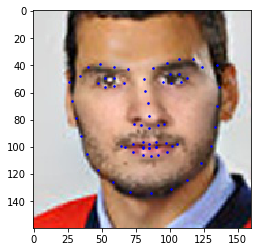

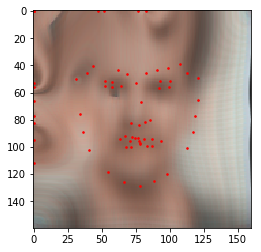

Iter: 410/983 Training loss: X = 103.5778, Y = 88.2574, T = 4.5135, W = 0.0918
Iter: 420/983 Training loss: X = 103.2657, Y = 90.2581, T = 4.0054, W = 0.0884
Iter: 430/983 Training loss: X = 102.5922, Y = 96.9518, T = 4.0795, W = 0.0775
Iter: 440/983 Training loss: X = 110.3243, Y = 89.8673, T = 5.2945, W = 0.0822
Iter: 450/983 Training loss: X = 106.2866, Y = 88.9274, T = 5.4017, W = 0.0892
Iter: 460/983 Training loss: X = 109.5071, Y = 89.4225, T = 5.5200, W = 0.0958
Iter: 470/983 Training loss: X = 104.8890, Y = 87.5072, T = 5.2807, W = 0.0839
Iter: 480/983 Training loss: X = 108.5029, Y = 104.9131, T = 5.2948, W = 0.0860
Iter: 490/983 Training loss: X = 123.6046, Y = 110.0680, T = 4.4250, W = 0.0828
Iter: 500/983 Training loss: X = 110.2645, Y = 86.6791, T = 5.8500, W = 0.0848


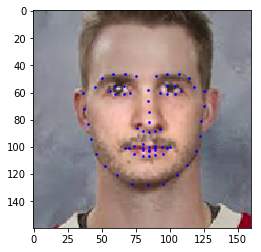

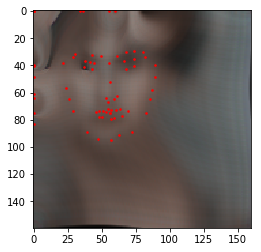

Iter: 510/983 Training loss: X = 112.1562, Y = 88.7904, T = 6.6143, W = 0.0753
Iter: 520/983 Training loss: X = 111.9964, Y = 87.3550, T = 4.8761, W = 0.0821
Iter: 530/983 Training loss: X = 115.0179, Y = 89.1733, T = 5.7117, W = 0.0949
Iter: 540/983 Training loss: X = 107.2784, Y = 87.5641, T = 5.6093, W = 0.0921
Iter: 550/983 Training loss: X = 112.2131, Y = 91.4863, T = 6.5947, W = 0.0794
Iter: 560/983 Training loss: X = 109.7427, Y = 97.8971, T = 4.3378, W = 0.0828
Iter: 570/983 Training loss: X = 116.1315, Y = 87.2476, T = 5.7113, W = 0.0764
Iter: 580/983 Training loss: X = 121.2756, Y = 90.3851, T = 5.8336, W = 0.0831
Iter: 590/983 Training loss: X = 108.7286, Y = 89.0054, T = 5.8616, W = 0.0838
Iter: 600/983 Training loss: X = 116.5183, Y = 86.7377, T = 4.1051, W = 0.0863


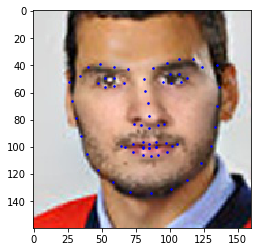

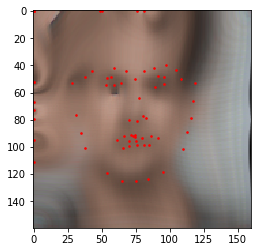

Iter: 610/983 Training loss: X = 100.6902, Y = 83.2936, T = 5.4404, W = 0.0752
Iter: 620/983 Training loss: X = 113.3036, Y = 92.9536, T = 5.3347, W = 0.0833
Iter: 630/983 Training loss: X = 110.3142, Y = 81.9536, T = 6.7283, W = 0.0886
Iter: 640/983 Training loss: X = 103.9347, Y = 82.9090, T = 5.7737, W = 0.0892
Iter: 650/983 Training loss: X = 112.2771, Y = 93.7846, T = 6.9498, W = 0.0960
Iter: 660/983 Training loss: X = 104.7140, Y = 85.0644, T = 4.8382, W = 0.1117
Iter: 670/983 Training loss: X = 123.8290, Y = 94.0054, T = 7.2304, W = 0.0862
Iter: 680/983 Training loss: X = 115.1765, Y = 97.3881, T = 4.0347, W = 0.0934
Iter: 690/983 Training loss: X = 109.3972, Y = 88.7311, T = 3.5410, W = 0.0950
Iter: 700/983 Training loss: X = 116.7618, Y = 86.2761, T = 4.6772, W = 0.0968


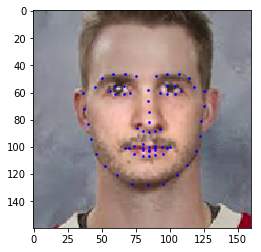

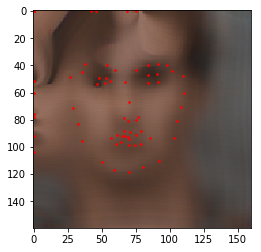

Iter: 710/983 Training loss: X = 106.5137, Y = 86.4903, T = 7.2723, W = 0.0771
Iter: 720/983 Training loss: X = 106.8099, Y = 82.5691, T = 6.2312, W = 0.0967
Iter: 730/983 Training loss: X = 107.9755, Y = 99.1627, T = 5.9356, W = 0.0972
Iter: 740/983 Training loss: X = 108.7991, Y = 89.0088, T = 3.6435, W = 0.0749
Iter: 750/983 Training loss: X = 120.8657, Y = 93.2790, T = 3.7359, W = 0.0951
Iter: 760/983 Training loss: X = 110.0307, Y = 93.6915, T = 4.5348, W = 0.0824
Iter: 770/983 Training loss: X = 106.0375, Y = 95.8103, T = 5.6902, W = 0.0921
Iter: 780/983 Training loss: X = 112.5454, Y = 99.0044, T = 5.2194, W = 0.1001
Iter: 790/983 Training loss: X = 104.9759, Y = 91.0376, T = 4.5960, W = 0.0946
Iter: 800/983 Training loss: X = 107.1322, Y = 89.6241, T = 5.4938, W = 0.0948


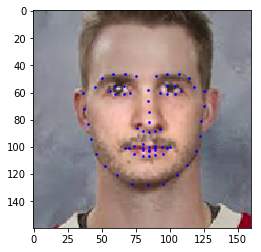

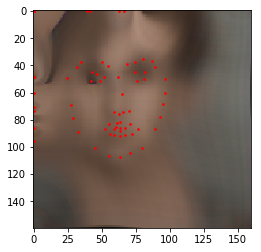

Iter: 810/983 Training loss: X = 111.8986, Y = 97.7425, T = 4.2498, W = 0.1011
Iter: 820/983 Training loss: X = 110.0492, Y = 83.2113, T = 5.6362, W = 0.1062
Iter: 830/983 Training loss: X = 114.2774, Y = 90.5257, T = 4.2157, W = 0.0826
Iter: 840/983 Training loss: X = 117.4268, Y = 98.2306, T = 4.6536, W = 0.0987
Iter: 850/983 Training loss: X = 117.7448, Y = 86.0445, T = 4.1071, W = 0.0805
Iter: 860/983 Training loss: X = 114.1405, Y = 88.9551, T = 8.8610, W = 0.1000
Iter: 870/983 Training loss: X = 108.9814, Y = 87.1422, T = 4.6751, W = 0.0841
Iter: 880/983 Training loss: X = 103.7356, Y = 78.0765, T = 4.0089, W = 0.0959
Iter: 890/983 Training loss: X = 104.3883, Y = 91.7605, T = 4.4913, W = 0.0996
Iter: 900/983 Training loss: X = 103.2758, Y = 94.4092, T = 3.8869, W = 0.0910


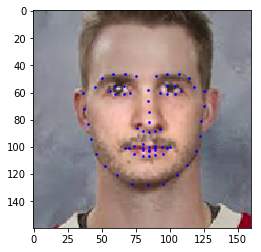

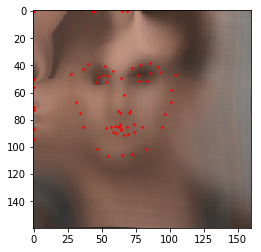

Iter: 910/983 Training loss: X = 110.4165, Y = 95.6960, T = 4.3122, W = 0.0897
Iter: 920/983 Training loss: X = 109.3570, Y = 83.0750, T = 2.9557, W = 0.0918
Iter: 930/983 Training loss: X = 102.5145, Y = 77.6907, T = 3.5563, W = 0.0875
Iter: 940/983 Training loss: X = 103.4430, Y = 80.2017, T = 4.9266, W = 0.0841
Iter: 950/983 Training loss: X = 102.8285, Y = 89.0915, T = 4.9444, W = 0.0784
Iter: 960/983 Training loss: X = 110.7321, Y = 92.2490, T = 4.8720, W = 0.0897
Iter: 970/983 Training loss: X = 108.5214, Y = 83.3630, T = 4.6913, W = 0.0810
Iter: 980/983 Training loss: X = 115.0238, Y = 96.3794, T = 5.3453, W = 0.0885
Epoch: 3/200 Time: 1327.783322095871
Model saved in file: ./tmp/model_1.ckpt Time: 1333.0835402011871
Iter: 10/983 Training loss: X = 110.4560, Y = 87.9589, T = 5.3695, W = 0.0921
Iter: 20/983 Training loss: X = 108.9888, Y = 83.2987, T = 4.3984, W = 0.0822
Iter: 30/983 Training loss: X = 123.1684, Y = 105.7162, T = 4.9706, W = 0.0926
Iter: 40/983 Training loss: X =

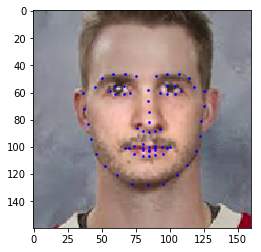

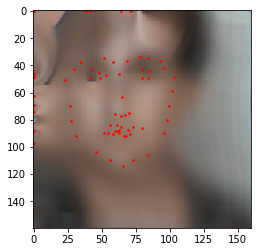

Iter: 110/983 Training loss: X = 113.2273, Y = 93.6124, T = 4.1835, W = 0.0884
Iter: 120/983 Training loss: X = 109.7831, Y = 91.8822, T = 5.1048, W = 0.0870
Iter: 130/983 Training loss: X = 118.3130, Y = 107.6621, T = 5.4160, W = 0.0967
Iter: 140/983 Training loss: X = 110.8624, Y = 92.7863, T = 3.7718, W = 0.0984
Iter: 150/983 Training loss: X = 144.9441, Y = 120.4636, T = 5.5438, W = 0.0909
Iter: 160/983 Training loss: X = 108.2876, Y = 89.7566, T = 4.7627, W = 0.0870
Iter: 170/983 Training loss: X = 116.8116, Y = 97.7547, T = 5.5473, W = 0.0891
Iter: 180/983 Training loss: X = 115.1821, Y = 104.0681, T = 5.0453, W = 0.1015
Iter: 190/983 Training loss: X = 105.6572, Y = 89.8611, T = 3.6727, W = 0.0979
Iter: 200/983 Training loss: X = 134.8946, Y = 120.2548, T = 4.8266, W = 0.1041


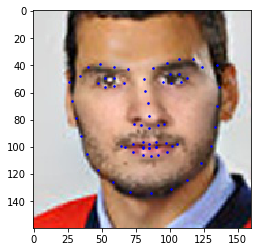

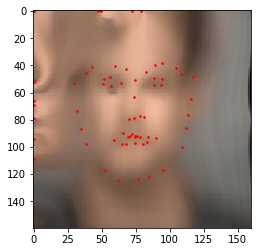

Iter: 210/983 Training loss: X = 108.3622, Y = 102.5000, T = 4.3168, W = 0.0868
Iter: 220/983 Training loss: X = 98.2318, Y = 83.3562, T = 3.4794, W = 0.1090
Iter: 230/983 Training loss: X = 106.5126, Y = 104.9169, T = 4.4869, W = 0.1078
Iter: 240/983 Training loss: X = 110.4933, Y = 88.5372, T = 5.0804, W = 0.0743
Iter: 250/983 Training loss: X = 112.7306, Y = 116.3714, T = 4.2589, W = 0.0981
Iter: 260/983 Training loss: X = 114.6065, Y = 97.1722, T = 4.7759, W = 0.0957
Iter: 270/983 Training loss: X = 115.5384, Y = 99.9340, T = 5.1827, W = 0.0999
Iter: 280/983 Training loss: X = 106.3740, Y = 92.6072, T = 4.0680, W = 0.0969
Iter: 290/983 Training loss: X = 115.9072, Y = 91.4692, T = 3.9468, W = 0.0901
Iter: 300/983 Training loss: X = 175.6312, Y = 144.8600, T = 5.4434, W = 0.0958


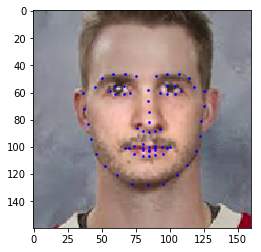

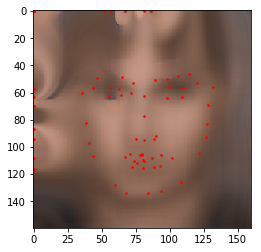

Iter: 310/983 Training loss: X = 122.9760, Y = 102.0021, T = 5.8685, W = 0.0863
Iter: 320/983 Training loss: X = 132.4069, Y = 121.3056, T = 4.5165, W = 0.0890
Iter: 330/983 Training loss: X = 107.0963, Y = 105.1896, T = 4.2746, W = 0.0903
Iter: 340/983 Training loss: X = 100.3114, Y = 93.4706, T = 6.3193, W = 0.0920
Iter: 350/983 Training loss: X = 111.5078, Y = 90.8549, T = 5.5595, W = 0.0814
Iter: 360/983 Training loss: X = 102.6708, Y = 96.0651, T = 4.6933, W = 0.0959
Iter: 370/983 Training loss: X = 195.5603, Y = 187.3407, T = 6.0559, W = 0.1077
Iter: 380/983 Training loss: X = 113.7328, Y = 98.5172, T = 3.7936, W = 0.0902
Iter: 390/983 Training loss: X = 105.8907, Y = 97.0157, T = 4.6739, W = 0.0966
Iter: 400/983 Training loss: X = 99.9987, Y = 81.6657, T = 3.7112, W = 0.0790


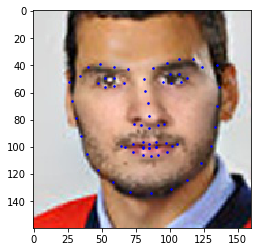

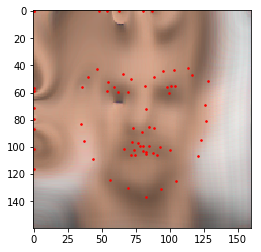

Iter: 410/983 Training loss: X = 129.5008, Y = 115.4952, T = 4.7230, W = 0.0883
Iter: 420/983 Training loss: X = 107.6746, Y = 104.0636, T = 3.9531, W = 0.0863
Iter: 430/983 Training loss: X = 96.7629, Y = 94.7317, T = 3.8667, W = 0.0749
Iter: 440/983 Training loss: X = 110.6391, Y = 96.2573, T = 5.1379, W = 0.0811
Iter: 450/983 Training loss: X = 103.0715, Y = 93.8045, T = 5.7083, W = 0.0906
Iter: 460/983 Training loss: X = 102.0380, Y = 93.8413, T = 5.7219, W = 0.0943
Iter: 470/983 Training loss: X = 98.3619, Y = 81.7412, T = 4.7644, W = 0.0814
Iter: 480/983 Training loss: X = 100.6517, Y = 93.7473, T = 4.6339, W = 0.0842
Iter: 490/983 Training loss: X = 117.1142, Y = 108.5433, T = 4.5220, W = 0.0828
Iter: 500/983 Training loss: X = 110.7301, Y = 94.1615, T = 5.3062, W = 0.0856


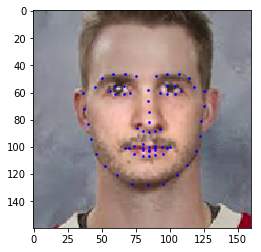

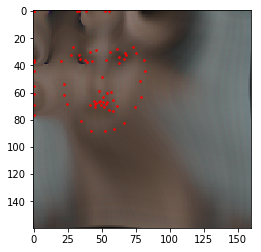

Iter: 510/983 Training loss: X = 111.8709, Y = 96.9628, T = 5.7689, W = 0.0758
Iter: 520/983 Training loss: X = 110.6037, Y = 96.5501, T = 4.7660, W = 0.0797
Iter: 530/983 Training loss: X = 103.6293, Y = 84.9901, T = 5.7371, W = 0.0956
Iter: 540/983 Training loss: X = 101.6398, Y = 89.3064, T = 5.5870, W = 0.0915
Iter: 550/983 Training loss: X = 105.7682, Y = 90.3056, T = 6.0397, W = 0.0783
Iter: 560/983 Training loss: X = 107.3549, Y = 100.6578, T = 3.9171, W = 0.0838
Iter: 570/983 Training loss: X = 110.4496, Y = 87.2292, T = 5.3546, W = 0.0743
Iter: 580/983 Training loss: X = 116.4001, Y = 103.9942, T = 4.0898, W = 0.0791
Iter: 590/983 Training loss: X = 101.9222, Y = 87.0306, T = 6.0070, W = 0.0823
Iter: 600/983 Training loss: X = 110.8588, Y = 87.8884, T = 4.5497, W = 0.0799


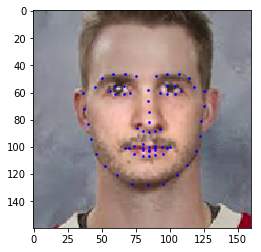

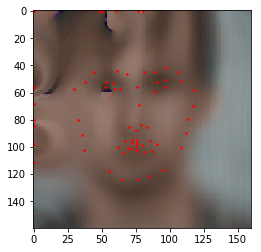

Iter: 610/983 Training loss: X = 100.7152, Y = 90.3211, T = 5.2035, W = 0.0724
Iter: 620/983 Training loss: X = 103.3251, Y = 88.6705, T = 5.6199, W = 0.0848
Iter: 630/983 Training loss: X = 105.4636, Y = 84.1240, T = 6.8629, W = 0.0899
Iter: 640/983 Training loss: X = 95.9415, Y = 80.7142, T = 5.7651, W = 0.0871
Iter: 650/983 Training loss: X = 135.6982, Y = 117.7354, T = 6.7947, W = 0.0962
Iter: 660/983 Training loss: X = 99.2286, Y = 86.2018, T = 4.8574, W = 0.1120
Iter: 670/983 Training loss: X = 110.1341, Y = 88.0956, T = 6.8845, W = 0.0884
Iter: 680/983 Training loss: X = 96.7752, Y = 83.1531, T = 3.8365, W = 0.0934
Iter: 690/983 Training loss: X = 99.2707, Y = 82.4974, T = 3.2911, W = 0.0958
Iter: 700/983 Training loss: X = 109.0225, Y = 84.8803, T = 4.4603, W = 0.0924


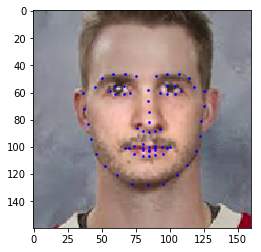

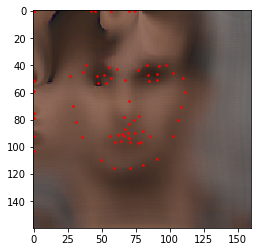

Iter: 710/983 Training loss: X = 101.6365, Y = 87.5799, T = 8.7661, W = 0.0770
Iter: 720/983 Training loss: X = 116.7797, Y = 102.8707, T = 4.6615, W = 0.0946
Iter: 730/983 Training loss: X = 95.5073, Y = 83.8849, T = 4.6390, W = 0.0991
Iter: 740/983 Training loss: X = 108.2181, Y = 84.1795, T = 3.8052, W = 0.0748
Iter: 750/983 Training loss: X = 129.8962, Y = 99.7873, T = 3.4886, W = 0.0922
Iter: 760/983 Training loss: X = 102.1972, Y = 88.2529, T = 5.2698, W = 0.0798
Iter: 770/983 Training loss: X = 109.2021, Y = 111.4136, T = 5.4224, W = 0.0901
Iter: 780/983 Training loss: X = 106.7844, Y = 90.9170, T = 5.5449, W = 0.0993
Iter: 790/983 Training loss: X = 101.9526, Y = 93.8484, T = 4.7013, W = 0.0957
Iter: 800/983 Training loss: X = 104.3999, Y = 86.9891, T = 5.8439, W = 0.0944


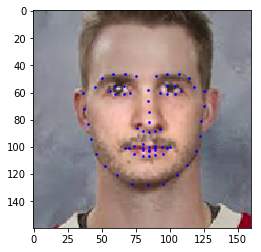

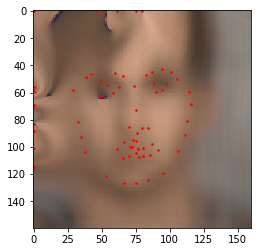

Iter: 810/983 Training loss: X = 105.9176, Y = 99.2415, T = 4.1271, W = 0.1000
Iter: 820/983 Training loss: X = 142.4585, Y = 107.9325, T = 6.4911, W = 0.1077
Iter: 830/983 Training loss: X = 111.8699, Y = 89.9405, T = 4.0428, W = 0.0828
Iter: 840/983 Training loss: X = 103.9359, Y = 95.2358, T = 4.2357, W = 0.0984
Iter: 850/983 Training loss: X = 109.3070, Y = 88.5351, T = 4.1185, W = 0.0789
Iter: 860/983 Training loss: X = 115.0096, Y = 95.2169, T = 8.1029, W = 0.1017
Iter: 870/983 Training loss: X = 106.5551, Y = 85.9143, T = 4.2748, W = 0.0873
Iter: 880/983 Training loss: X = 97.4275, Y = 82.0278, T = 4.8258, W = 0.0988
Iter: 890/983 Training loss: X = 99.8615, Y = 96.1730, T = 4.9970, W = 0.1000
Iter: 900/983 Training loss: X = 95.1301, Y = 95.6821, T = 4.2693, W = 0.0888


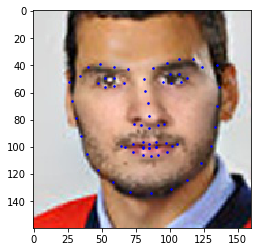

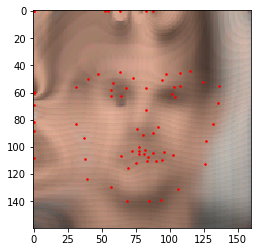

Iter: 910/983 Training loss: X = 92.5994, Y = 83.1260, T = 3.6867, W = 0.0892
Iter: 920/983 Training loss: X = 101.0077, Y = 85.0995, T = 3.1537, W = 0.0890
Iter: 930/983 Training loss: X = 93.9440, Y = 79.8843, T = 3.4509, W = 0.0862
Iter: 940/983 Training loss: X = 100.5581, Y = 87.1455, T = 5.1440, W = 0.0829
Iter: 950/983 Training loss: X = 95.9135, Y = 91.7288, T = 5.1431, W = 0.0754
Iter: 960/983 Training loss: X = 120.5556, Y = 111.0202, T = 4.9276, W = 0.0885
Iter: 970/983 Training loss: X = 110.0929, Y = 100.1489, T = 5.6771, W = 0.0772
Iter: 980/983 Training loss: X = 111.2342, Y = 118.2104, T = 5.3063, W = 0.0862
Epoch: 4/200 Time: 1772.5230972766876
Model saved in file: ./tmp/model_1.ckpt Time: 1777.7819528579712
Iter: 10/983 Training loss: X = 100.0779, Y = 86.3861, T = 5.2246, W = 0.0951
Iter: 20/983 Training loss: X = 105.5180, Y = 89.2107, T = 4.2952, W = 0.0830
Iter: 30/983 Training loss: X = 123.6095, Y = 122.5654, T = 5.1781, W = 0.0911
Iter: 40/983 Training loss: X 

In [ ]:
with g.as_default():
    with sess.as_default() :
        start_test = time.time()
        
        for e in range(epochs):
            log_index = 10
            l_x_cost_sum = 0
            l_y_cost_sum = 0
            t_cost_sum = 0
            w_cost_sum = 0
            
            for i, ((f_avgP, f_emb), t_label_batch) in enumerate(zip(train_set, t_dataset.get_batches(batch_size))):
                start = i * batch_size
                end = min(start+batch_size, len(train_set) * batch_size)
                size = end - start

                l_labels = landmarks_frame.ix[start:end - 1, 1:].as_matrix().astype('float32').reshape(size, l_num, 2)
                
                run = [#summary_op,
                       l_x_loss, 
                       l_y_loss, 
                       t_loss, 
                       w_loss,
                       apply_grads, l_x_preds, l_y_preds]
                
                feed_dict = {avgP_inputs : f_avgP.reshape(-1, avgP_num),
                             l_x_labels : l_labels[:, :, 0].reshape(-1, l_num), 
                             l_y_labels : l_labels[:, :, 1].reshape(-1, l_num),
                             t_labels : t_label_batch, 
                             w_labels : f_emb.reshape(-1, emb_num), 
                             f_phase_train_placeholder:False}

                out = sess.run(run, feed_dict= feed_dict)
                (#summary,
                 l_x_cost, 
                 l_y_cost, 
                 t_cost, 
                 w_cost, 
                 _, _l_x, _l_y) = out
                
                l_x_cost_sum += l_x_cost
                l_y_cost_sum += l_y_cost
                t_cost_sum += t_cost
                w_cost_sum += w_cost
                
                if (i+1) % log_index == 0 :
                    print("Iter: {}/{}".format(i+1, len(train_set)),\
                              "Training loss: X = {:.4f}, Y = {:.4f}, T = {:.4f}, W = {:.4f}".format(l_x_cost / log_index, 
                                                                                                     l_y_cost / log_index, 
                                                                                                     t_cost / log_index, 
                                                                                                     w_cost / log_index))
                    l_x_cost_sum = 0
                    l_y_cost_sum = 0
                    t_cost_sum = 0
                    w_cost_sum = 0

                if (i+1) % 100 == 0 :
                    test_index = random.randint(0, len(test_set[0])-1)
                    test_avgP = test_set[0][0][test_index] 
                    t_landmarks = get_landmarks(test_index)
                    
                    t_img = t_landmarks[0]
                    t_l_labels = t_landmarks[1:].as_matrix().astype('float32').reshape(-1, 2)
                    
                    test_run = [l_x_preds, l_y_preds, t_preds, warp_t]
                    test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num),
                                 l_x_labels : t_l_labels[:, 0].reshape(-1, l_num), 
                                 l_y_labels : t_l_labels[:, 1].reshape(-1, l_num)}
                    
                    t_l_x, t_l_y, t_t, t_w = sess.run(test_run, feed_dict= test_feed)
                    show_test(t_l_x.reshape(l_num), 
                              t_l_y.reshape(l_num), 
                              t_t.reshape(t_size, t_size, t_channel),
                              t_w.reshape(t_size, t_size, t_channel), 
                              t_img, 
                              t_l_labels)
                # summary_writer.add_summary(summary, e * len(train_set) + i)
                
            print("Epoch: {}/{}".format(e+1, epochs), "Time: %s" % (time.time() - start_test))
            
            saver = tf.train.Saver()
            save_path = saver.save(sess, "./tmp/model_1.ckpt")
            print("Model saved in file: %s" % save_path, "Time: %s" % (time.time() - start_test))

# Embeding Facenet

In [ ]:
def load_and_align_data(image_paths, image_size, margin, gpu_memory_fraction):

    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor
    
    print('Creating networks and loading parameters')
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
  
    nrof_samples = len(image_paths)
    img_list = [None] * nrof_samples
    for i in range(nrof_samples):
        img = misc.imread(os.path.expanduser(image_paths[i]))
        if (img.shape[2] == 4):
            img = img[:, :, :3]
        img_size = np.asarray(img.shape)[0:2]
        bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
        det = np.squeeze(bounding_boxes[0,0:4])
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img_size[1])
        bb[3] = np.minimum(det[3]+margin/2, img_size[0])
        cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
        aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
        prewhitened = facenet.prewhiten(aligned)
        img_list[i] = prewhitened
        sys.stdout.write('\r'+ '%d/%d'%(i, nrof_samples))
    images = np.stack(img_list)
    return images

In [48]:
batch_size = 8

f_emb_g = tf.Graph()
f_emb_list = []
f_avgP_list = []

In [1]:
with f_emb_g.as_default():
    time_load_data = time.time()
    print("--- data loading start ---")
    images = load_and_align_data(file_list[:10], 110, 0, 1.0)
    print("--- %s data loaded ---" % (time.time() - time_load_data))
    
    with tf.Session() as sess:
        start_load_facenet = time.time()
        print("--- %s start load facenet ---" % (start_load_facenet))
        facenet.load_model('./20171012')
        print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

        # Get input and output tensors
        f_inputs = tf.get_default_graph().get_tensor_by_name("input:0")
        f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        f_avgP_logits = tf.get_default_graph().get_tensor_by_name("InceptionResnetV1/Logits/AvgPool_1a_8x8/AvgPool:0")
        f_emb_logits = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        
        start_test = time.time()
        
        total_size = len(images)
        for i in range(0, total_size, batch_size):
            batch = images[i:min(i+batch_size, total_size)]
            f_feed = {f_inputs: batch, f_phase_train_placeholder:False}
            f_embedings, f_avgPool = sess.run([f_emb_logits, f_avgP_logits], feed_dict=f_feed)
            f_emb_list.append(f_embedings)
            f_avgP_list.append(f_avgPool)
            sys.stdout.write('\r'+ "[%d/%d] %s" % (i, total_size, time.time() - start_test))
            print()
        print("--- %s seconds ---" % (time.time() - start_test))

NameError: name 'f_emb_g' is not defined

In [28]:
np.savez('f_emb_list.npz', *f_emb_list)
np.savez('f_avgP_list.npz', *f_avgP_list)

In [54]:
print(images.shape)

(7867, 160, 160, 3)
